# Giới thiệu

Trong bài tập này, chúng ta sẽ thực hành implement GCN dựa trên paper [GCN](https://arxiv.org/pdf/1609.02907.pdf).

- Những bước cần phải làm:
  1.   Đọc data từ file và lưu về dạng mô hình có thể xử lý 
  2.   Tạo Node Embedding sử dụng thuật toán DeepWalk. Từ đó, ta có thể tạo được feature embedding 
  3.   Tạo adjacency matrix 
  4.   Sử dụng adjacency matrix và node embedding để làm đầu vào cho mô hình GCN
  5.   Implement mô hình GCN với đầu ra là bài toán  classification.

- Mô tả dataset: Bộ dataset này miêu tả một mạng xã hội, với các node là người trong mạng đó. Mỗi người có một role, và một community mà ngừoi đó thuộc về 
  1.   ex_edgelist.txt: Một danh sách miêu tả node nào được nối với nhau => Ta có thể tạo ma trận kề từ file này  
  2.   ex_attributes.csv: Danh sách các feature của từng node. Mỗi node  sẽ có 2 feature, "role" và "community"

- Mục tiêu bài tập:
  Sử dụng lớp GCN như một classifier để quyết định "member" trong mạng thuộc về community "administrator" hay "instructor"

- Note:
  1. Điền code vào phần được đánh dấu là bài tập, các phần khác được implement sẵn để các bạn hiểu được flow tổng thể của một bài toán sử dụng GNN 
  2. Sử dụng "Table of contents" để tìm phần "bài tập" một cách nhanh hơn 

# Bài tập

## Packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import random

In [2]:
# set seed cho random 
torch.manual_seed(49)
random.seed(49)
np.random.seed(49)

## Tải dữ liệu và các đặt các packages cần thiết

In [3]:
!gdown --id "18NI2HRLStk5hwuE7B-woIlcFKJHyKK5I"


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18NI2HRLStk5hwuE7B-woIlcFKJHyKK5I
To: /workspace/nabang1010/LBA_VAIPE/GNN/Multi_Label_Image_Recognition_with_Graph_Convolutional_Networks/exercise.rar
100%|██████████████████████████████████████| 1.06k/1.06k [00:00<00:00, 1.37MB/s]


### **Giới thiệu lại về đồ thị**

Đồ thị là một cấu trúc dữ liệu có thể được biểu diễn dưới dạng **G=<V,E>**, với **V** là tập các đỉnh, **E** là tập cạnh nối các đỉnh 

### Giới thiệu thư viện 

**Networkx** là một package trong python để tạo, visualize và thao tác trên các mạng phức tạp 

Link: [Networkx](https://networkx.org).

Các datastructure trong networkx bao gồm:
  1.   Graph: Normal Graph (vô hướng)
  2.   DiGraph: Directed Graph (có hướng)
  3.   Multigraph: Đa đồ thị 



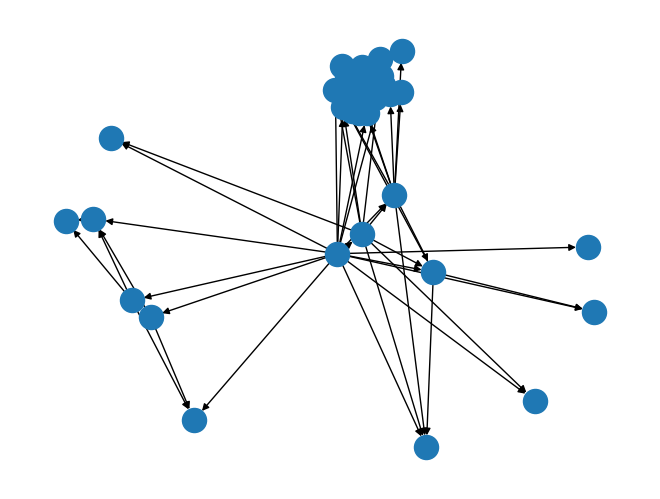

In [4]:
# Đọc Graph từ file  
G_inp = nx.read_edgelist("/workspace/nabang1010/LBA_VAIPE/GNN/Multi_Label_Image_Recognition_with_Graph_Convolutional_Networks/ex/ex_edgelist.txt", create_using=nx.DiGraph())
# Tạo graph 
## Graph 
G  = nx.Graph()
## DiGraph 
DiG = nx.DiGraph()
## MultiGraph 
MG = nx.MultiGraph()
## Tạo graph sử dụng adjacency list 
G_adj = nx.Graph({0: (1, 2), 1: (0, 2), 2: (0, 1)})  
# Các thao tác trên Graph 
## Thêm đỉnh 
G.add_node(1) # thêm đỉnh 
G.add_nodes_from([2,3,4]) # thêm một list các đỉnh 
G.add_nodes_from([ # thêm đỉnh kèm theo attribute 
    (4, {"color": "red"}),
    (5, {"color": "green"}),
])
H = nx.path_graph(10) # thêm đỉnh từ một graph khác 
G.add_nodes_from(H)
## Thêm cạnh 
G.add_edge(1, 2) # thêm từng cạnh 
G.add_edges_from([(1, 2), (1, 3)]) # thêm một list các cạnh 
## Xoá 
G.remove_node(2)  # Xoá đỉnh   
G.remove_edge(1,3) # Xoá cạnh 
# Vẽ graph 
nx.draw(G_inp)

### Visualize dữ liệu

In [5]:
# Ta xem tiết file ex_attribute.csv để hiểu tính chất của các node 
edge_attr = pd.read_csv("ex/ex_attributes.csv")
edge_attr.tail()

,node,role,community
29,29,Member,Instructor
30,30,Member,Instructor
31,31,Member,Instructor
32,32,Member,Instructor
33,33,Instructor,Instructor


In [6]:
# Ta đọc xem mỗi community có số lượng bao nhiêu node 
edge_attr.groupby(["community"]).count()

,node,role
community,,
Administrator,17,17
Instructor,17,17


In [7]:
# Liệt kê danh sách các community 
lst_commu = list(set(edge_attr["community"].tolist()))
print(lst_commu)

['Instructor', 'Administrator']


In [8]:
# Liệt kê danh sách các role có thể 
lst_role = list(set(edge_attr["role"].tolist()))
print(lst_role)

['Instructor', 'Member', 'Administrator']


## Tiện ích: Xử lý dữ liệu

### [TO DO 1] Xây dựng đồ thị và ma trận kề 
- Tạo graph với node có attribute tương ứng 
- Tạo ma trận kề  từ file ex_edgelist.txt
  1. Shape: (node, node)
  2. Type: array (numpy)

In [9]:
# Todo
def create_graph_with_attributes(edgelist_filepath, attributes_filepath):
  '''
    Description: Tạo đồ thị vô hướng với các node chứa attribute đọc từ file attribute 
    Input: File các cạnh, file attribute của từng node 
    Output: graph 
  '''

  # TODO: Tạo đồ thị vô hướng sử dụng nx.read_edgelist
  graph = nx.read_edgelist(edgelist_filepath, create_using=nx.Graph())

  # TODO: Đọc file attribute 
  attributes = pd.read_csv(attributes_filepath)
  
  # Tạo một dictionary với key là node_id, value là value của attribute 
  att_values = {a:{'role':b[0],'community':b[1]} for a,b in enumerate(attributes.values)}
  # TODO: Set attribute cho các node tương ứng sử dụng nx.set_node_attributes
  nx.set_node_attributes(graph, att_values)
  
  return graph

def create_adj_matrix(graph):
  '''
    Description: Tạo ma trận kề sử dụng hàm nx.to_numpy_matrix
    Input: graph
    Output: numpy array 
  '''
  # Sử dụng nx.to_numpy_matrix để chuyển từ nx sang np
  graph_np = nx.to_numpy_matrix(graph)
  return graph_np

### Xây dựng Node embedding 

#### Lý thuyết:

**Graph Embedding là gì?**

Để  biểu diễn Graph, chúng ta có 2 hướng tiếp cận chính:

*   Hướng đầu tiên sử dụng mô hình graph truyền thống với các node và cạnh, các node được nối với nhau bằng một cạnh được gọi là hàng xóm của nhau (neighbour)
*   Tuy vậy, nếu biểu diễn dưới dạng này, các mô hình học máy hay học sâu không thể học được. Do đó, người ta nghĩ ra việc chuyển mô hình graph về dạng embedding domain, với mỗi node được biểu diễn dưới dạng một continuous vector. 
*   Node embedding sẽ có chiều là [số node, len(feature_vector)] 

**Hướng tiếp cận**

Để xây dựng embedding vector cho graph, trước hết ta cần trả lời 2 câu hỏi:

*   Ta cần giữ các thuộc tính gì khi xây dựng embedding
*   Làm thế nào để xây dựng nên embedding đó?

Về câu hỏi thứ nhất, một số các nghiên cứu đã được thực hiện để giải quyết các bài toán liên quan đến:

1.   Lưu trữ thông tin của node hàng xóm [Link](https://arxiv.org/abs/1403.6652)
2.   Lưu trữ thông tin về kiến trúc của node [Link](https://arxiv.org/abs/1704.03165)
3.   Lưu trữ thông tin về trạng thái của node [Link](https://arxiv.org/abs/1710.07266)
4.   Lưu trữ thông tin về community [Link](https://www.aaai.org/ocs/index.php/AAAI/AAAI17/paper/download/14589/13763) 


Còn về câu hỏi thứ hai, một framework chung đã được thiết kế như hình vẽ dưới đây:

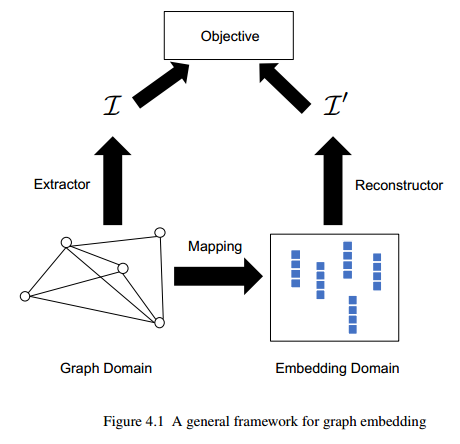




1.   **Mapping function**: Map từ graph domain sang embedding domain
2.   **Information extractor**: Lấy những thông tin quan trọng *I* mà ta muốn giữ từ graph-domain
3.   **Reconstructor**: Từ embedding domain, ta dùng reconstructor này để dựng lại các thông tin được trích rút trong phase 2, ta gọi graph information được dựng lại này là *I'*
4.   **Objective**: Đầu vào của objective function là thông tin gốc *I* và thông tin dựng lại *I'*. Ta muốn từ đây có thể minimize sự sai khác giữa *I* và *I'* trong quá trình học bằng cách thay đổi các bộ tham số của reconstructor 

**Mapping function** dưới dạng đơn giản nhất là: table lookup

Còn với **information extractor**, các thuật toán thường được xây dựng trên cơ chế random-walk based - DeepWalk

Tiếp theo chúng ta sẽ bắt tay xây dựng một graph embedding cơ bản 

#### [TO DO 2] Cách 1: Node embedding cơ bản chỉ sử dụng tính chất về khoảng cách 

Ta thử tạo một embedding vector cơ bản với:
  1. Shape: (số lượng đỉnh, số feature)
  2. Type: np.array 
  3. Input feature: Bao gồm 2 phần tử [shortest_path(cur_node, 0), shortest_path(cur_node, 33)] 

In [10]:
def create_node_embedding_simple(graph):
  # Tạo np.array từ graph 
  A = create_adj_matrix(graph)
  print("A = \n", A)
  
  # Tạo một ma trận có kích thước [số lượng đỉnh, 2]
  input_features = torch.zeros(A.shape[0], 2)
  
  # Sử dụng nx.shortest_length của từng node tới node 33
  node_distance_instructor = nx.shortest_path_length(graph, source="33")
  
  # Sử dụng nx.shortest_length của từng node tới node 0
  node_distance_administrator = nx.shortest_path_length(graph, source="0")
  
  # Với từng node trong graph, gán X[node] = [khoảng cách đến node 33, khoảng cách đến node 0]
  for node in graph.nodes():
    input_features[int(node)][0] = node_distance_instructor[node]
    input_features[int(node)][1] = node_distance_administrator[node]

  return input_features

In [11]:
g  = create_graph_with_attributes('ex/ex_edgelist.txt','ex/ex_attributes.csv')
ne_simple = create_node_embedding_simple(g)
ne_simple

A = 
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


tensor([[2., 0.],
        [2., 1.],
        [2., 1.],
        [2., 1.],
        [3., 1.],
        [3., 1.],
        [3., 1.],
        [3., 1.],
        [1., 1.],
        [1., 2.],
        [3., 1.],
        [3., 1.],
        [3., 1.],
        [1., 1.],
        [1., 3.],
        [1., 3.],
        [4., 2.],
        [3., 1.],
        [1., 3.],
        [1., 1.],
        [1., 3.],
        [3., 1.],
        [1., 3.],
        [1., 3.],
        [2., 2.],
        [2., 2.],
        [1., 3.],
        [1., 2.],
        [1., 2.],
        [1., 3.],
        [1., 2.],
        [1., 1.],
        [1., 2.],
        [0., 2.]])

#### Cách 2: Sử dụng các Node Embedding phức tạp hơn để giữ tính chất co-occurrence 

In [12]:
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
from gensim.models import Word2Vec

In [13]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

##### DeepWalk 

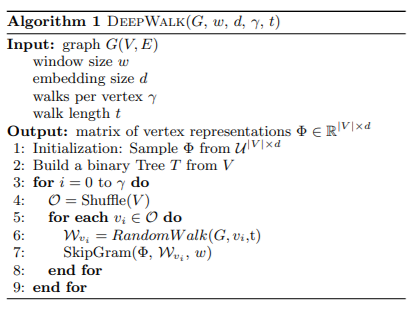

Class **RandomWalker** được sử dụng như Information Extractor

Về cơ bản, ta sẽ sử dụng hàm simulate_walks để tạo ra n=num_walks số lượt đi ngẫu nhiên giữa các node, với mỗi lượt sẽ đi qua độ dài=walk_length nodes 

Mỗi lượt đi được coi như một câu hoàn chỉnh, với các từ là các node đã được đi qua. 

Với RandomWalk, ta coi mỗi node neighbour đều có xác suất là 1/p được đi đến, với p là số lượng neighbour của node đang xét 

In [14]:
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks per vertex
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length


  def deepwalk_walk(self, start_node):
      """
      :param start_node: Starting node of a walk
      """
      walk = [start_node]
      while len(walk) < self.walk_length:
          cur = walk[-1]
          # Check if having any neighbors at the current node
          cur_nbrs = list(self.G.neighbors(cur))
          if len(cur_nbrs) > 0:
              # Random walk with the probability of 1/d(v^t). d(v^t) is the node degree
              walk.append(random.choice(cur_nbrs))
          else:
              break
      return walk


  def simulate_walks(self, workers=1, verbose=0):
      """
      :param workers: a number of workers running in parallel processing
      :param verbose: progress bar
      """
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)(nodes) for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks

  # INFORMATION EXTRACTOR
  def _simulate_walks(self, nodes):
      walks = []
      # Iterate all walks per vertex
      for _ in range(self.num_walks):
          random.shuffle(nodes)
          # Iterate all nodes in a walk
          for v in nodes:
            walks.append(self.deepwalk_walk(start_node=v))
      return walks

Sau đó ta cho tập các lượt đi qua mô hình Word2Vec để học được node embedding 

Chi tiết xem tại: [Word2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

In [15]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        # word to vec model
        self.w2v_model  = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.sentences = self.walker.simulate_walks(workers=workers, verbose=1)

    def train(self, embed_size=128, window_size=5, workers=1, iter=5, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["iter"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs) # Pay attention here
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self):
        # Lấy embedding của từng node, sau đó sắp xếp theo thứ tự node rồi stack thành 2D matrix 
        if self.w2v_model is None:
            print("model not train")
            return {}
        self._embeddings = {}
        for word in self.graph.nodes():
          self._embeddings[word] = self.w2v_model.wv[word]

        lst_arr = []
        for i in range(len(self._embeddings.keys())):
          # print('Step {}: {}'.format(i, self._embeddings[str(i)]))
          lst_arr.append(self._embeddings[str(i)])
        return torch.from_numpy(np.stack(lst_arr))

In [16]:
model = DeepWalk(g, walk_length=20, num_walks=80, workers=1) #init model
model.train(window_size=5, iter=3) # train model
ne_dw = model.get_embeddings() # get node embedding using deepwalk
ne_dw

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Learning embedding vectors...


TypeError: __init__() got an unexpected keyword argument 'size'

## Mô hình: Graph Convolutional Networks

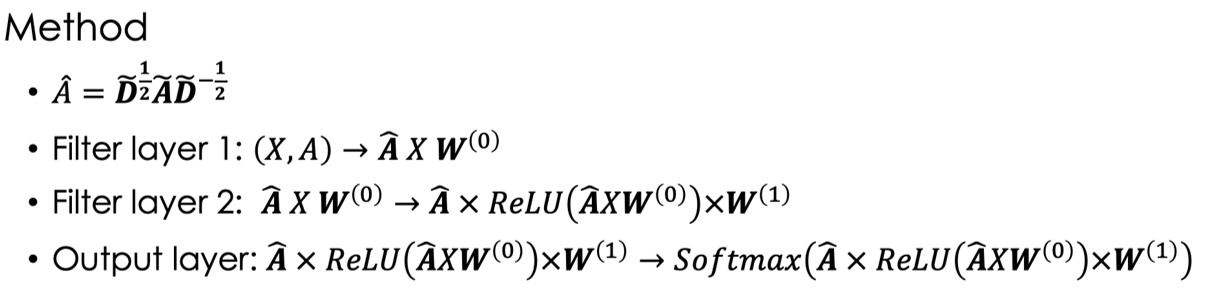

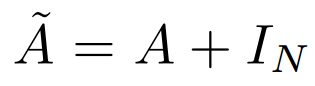

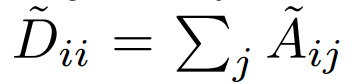

### [TO DO 3] Viết hàm tính A_hat trong class GCN_layer 


In [ ]:
from torch.nn.parameter import Parameter

class GCN_layer(nn.Module):
    def __init__(self, inputs_shape, outputs_shape):
        super(GCN_layer, self).__init__()
        # Khai báo một trainable matrix cho W  
        self.W=Parameter(torch.rand(inputs_shape,outputs_shape),requires_grad=True)
        # Khai báo một trainable matrix cho b
        self.bias = Parameter(torch.rand(outputs_shape),requires_grad=True)
        
    def forward(self, adj_matrix, input_features):
        # Khai báo một torch tensor sử dụng torch.from_numpy với kiểu Long 
        A= 
        
        # Tính ma trận I là identity_matrix cùng chiều với adj_matrix sử dụng torch.eye 
        I= None
        
        # Tính A_hat = A + I
        A_hat= None
        
        # Tính D = tổng các hàng ngang của ma trận A sử dụng torch.sum
        D = None
        
        # Tính D^-1/2 sử dụng torch.pow, sau đó sử dụng torch.diag để tạo ma trận chéo  
        D_norm = None
        
        # Tính A_hat = D^-1/2 * A_hat * D^-1/2 sử dụng torch.mm 
        A_hat = None
        
        # Nhân A_hat với input
        aggregate= None

        # Nhân kết qua của A_hat * input với W, sau đó cộng với bias 
        propagate= None

        return propagate

### [TO DO 4] Implement "forward" function trong class "GCN".

In [ ]:
class GCN(nn.Module):
    def __init__(self,inputs_shape,outputs_shape,n_classes,activation='Relu'):
        super(GCN, self).__init__()

        self.layer1=GCN_layer(inputs_shape,outputs_shape)
        self.layer2=GCN_layer(outputs_shape,n_classes)
        self.activation=nn.ReLU()
        self.softmax=nn.Softmax()
    
    def forward(self,adj_matrix,input_features):
      # Solution: Follow method in the image above:
      # Step 1: Put adj_matrix and input_features into self.layer1
      x= None
      
      # Step 2: Put the output of step 1 through activation "relu"
      x= None
      
      # Step 3: Put the output of step 2 through self.layer2
      x= None
      
      # Step 4: Put the output of step 3 through softmax
      x= None
      return x

In [ ]:
import torch
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx


class Trainer():
    def __init__(self,model,optimizer,loss_function,epochs,adj_matrix,input_features):
        
        self.model=model
        self.optimizer=optimizer
        self.loss_function=loss_function
        self.epochs=epochs
        self.adj_matrix = adj_matrix
        self.input_features = input_features
        
    def train(self,X_train,Y_train):
        y_train=torch.from_numpy(Y_train.astype(int)).type(torch.LongTensor)
        tot_loss=0.0
        all_preds=[]

        # Viết hàm train 
        for t in range(self.epochs):
            epoch_loss = 0.0

            y_pred=self.model(self.adj_matrix, self.input_features)
            all_preds.append(y_pred)
            loss = self.loss_function(y_pred[X_train], y_train)
            self.optimizer.zero_grad()
            epoch_loss+=loss
            tot_loss+=loss            # trả về kết quả dự đoán 

            loss.backward()
            self.optimizer.step()

            print(str(t),'epoch_loss:'+str(epoch_loss),'total loss:'+str(tot_loss))

        self.all_preds=all_preds
    
    def test(self,X_test,Y_test):
        self.model.eval()
        y_test=torch.from_numpy(Y_test.astype(int)).type(torch.LongTensor)
        y_pred=self.all_preds[-1]  # preds of last epoch
        loss_test = self.loss_function(y_pred[X_test],y_test)
        print('validation loss is equal to: '+str(loss_test))
    
    def visualize_classification(self,graph,Y_test,classification):
        last_epoch = self.all_preds[self.epochs-1].detach().numpy() # get outputs of last epoch
        predicted_class = np.argmax(last_epoch, axis=-1) # take the unit with the higher probability
        color = np.where(predicted_class==0, 'c', 'r')
        pos = nx.kamada_kawai_layout(graph)
        nx.draw_networkx(graph, pos, node_color=color, with_labels=True, node_size=300)
        if classification==True:
            print(classification_report(predicted_class[1:-1],Y_test))

## Thực thi GCN

In [ ]:
model_dw = DeepWalk(g, walk_length=20, num_walks=80, workers=1) #init model
model_dw.train(window_size=5, iter=3) # train model

In [ ]:
graph=create_graph_with_attributes('ex_edgelist.txt','ex_attributes.csv')
adj_matrix = create_adj_matrix(graph)
ne_simple = create_node_embedding_simple(graph)
ne_dw = model_dw.get_embeddings()

In [ ]:
X_train = np.load("X_train.npy")
Y_train = np.load("Y_train.npy")
X_test = np.load("X_test.npy")
Y_test = np.load("Y_test.npy")

### Kiểm thử với embedding đơn giản

In [ ]:
model=GCN(inputs_shape=ne_simple.shape[1],outputs_shape=4,n_classes=2)
trainer = Trainer(
    model,
    optimizer = optim.Adam(model.parameters(), lr=0.01),
    loss_function=F.cross_entropy,
    epochs=250,
    adj_matrix=adj_matrix,
    input_features=ne_simple
)

trainer.train(X_train,Y_train)
trainer.test(X_test,Y_test)
trainer.visualize_classification(graph,Y_test,classification=True)

### Kiểm thử với embedding sinh ra bởi random walk.

In [ ]:
model=GCN(inputs_shape=ne_dw.shape[1],outputs_shape=4,n_classes=2)

trainer = Trainer(
    model,
    optimizer = optim.Adam(model.parameters(), lr=0.01),
    loss_function=F.cross_entropy,
    epochs=250,
    adj_matrix=adj_matrix,
    input_features=ne_dw
)

trainer.train(X_train,Y_train)
trainer.test(X_test,Y_test)
trainer.visualize_classification(graph,Y_test,classification=True)